In [1]:
import pandas as pd
import ray
from multiprocessing import Process, Pipe
import xgboost as xgb
import numpy as np 
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
import tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec
from kpal.klib import Profile
from multiprocessing import Queue
from multiprocessing import Process
from Bio.Seq import Seq
from Bio import SeqIO
from multiprocessing import Pool, freeze_support
import itertools as it
import glob
import re

/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/pitikovegor/anaconda/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ve

In [2]:
all_models = glob.glob("/home/pitikovegor/CourseWork/genomes/models/xgb_*")

In [3]:
all_models =  [i for i in all_models if not ('.txt' in i)]

In [4]:
all_models

['/home/pitikovegor/CourseWork/genomes/models/xgb_trans_15:24:35_3_GSM4041595_K562_rep2.hg38',
 '/home/pitikovegor/CourseWork/genomes/models/xgb_clusters_10:36:58_4_try2_500_10',
 '/home/pitikovegor/CourseWork/genomes/models/xgb_clusters_12:03:40_4_try5_250_2',
 '/home/pitikovegor/CourseWork/genomes/models/xgb_clusters_18:04:13_3_try1',
 '/home/pitikovegor/CourseWork/genomes/models/xgb_clusters_13:56:30_1_try1',
 '/home/pitikovegor/CourseWork/genomes/models/xgb_clusters_16:40:43_4_try8_1000_1',
 '/home/pitikovegor/CourseWork/genomes/models/xgb_clusters_15:14:30_2_try1',
 '/home/pitikovegor/CourseWork/genomes/models/xgb_clusters_20:44:08_4_try9_6_1',
 '/home/pitikovegor/CourseWork/genomes/models/xgb_clusters_01:54:14_4_try1',
 '/home/pitikovegor/CourseWork/genomes/models/xgb_trans_18:09:47_4_GSM4041595_K562_rep2.hg38_6_1_3',
 '/home/pitikovegor/CourseWork/genomes/models/xgb_trans_06:20:55_4_GSM4041595_K562_rep2.hg38_500_2',
 '/home/pitikovegor/CourseWork/genomes/models/xgb_trans_15:55:2

In [17]:
modelname = 'xgb_clusters_10:36:58_4_try2_500_10'

In [18]:
bst = xgb.Booster({'nthread': 10})
bst.load_model('/home/pitikovegor/CourseWork/genomes/models/%s' % modelname) 

all_seqs = [''.join(i) for i in list(it.product('ATGC', repeat=4))]
all_seqs.sort()

In [7]:
features = bst.get_score(importance_type='gain')

In [8]:
features_rev = {y:x for x,y in features.items()}

In [9]:
if len(features)!=len(features_rev):
    raise DolboebException('2 or more features with similar weight')

In [10]:
keys_to_fetures = {i:all_seqs[int(i[1:])] for i in features.keys()}


In [11]:
top_10_names = list(features_rev.keys())
top_10_names.sort()
top_10_names = top_10_names[-10:]
top_10_names = top_10_names[::-1]
top_10_val = [features_rev[i] for i in top_10_names]

In [12]:
top_10_val = [all_seqs[int(i[1:])] for i in top_10_val]

In [13]:
top_10_val

['GAAG',
 'GGGG',
 'CGTC',
 'AGTT',
 'CACC',
 'GTTT',
 'CAAT',
 'AAGT',
 'TGCA',
 'CAGC']

No handles with labels found to put in legend.
No handles with labels found to put in legend.


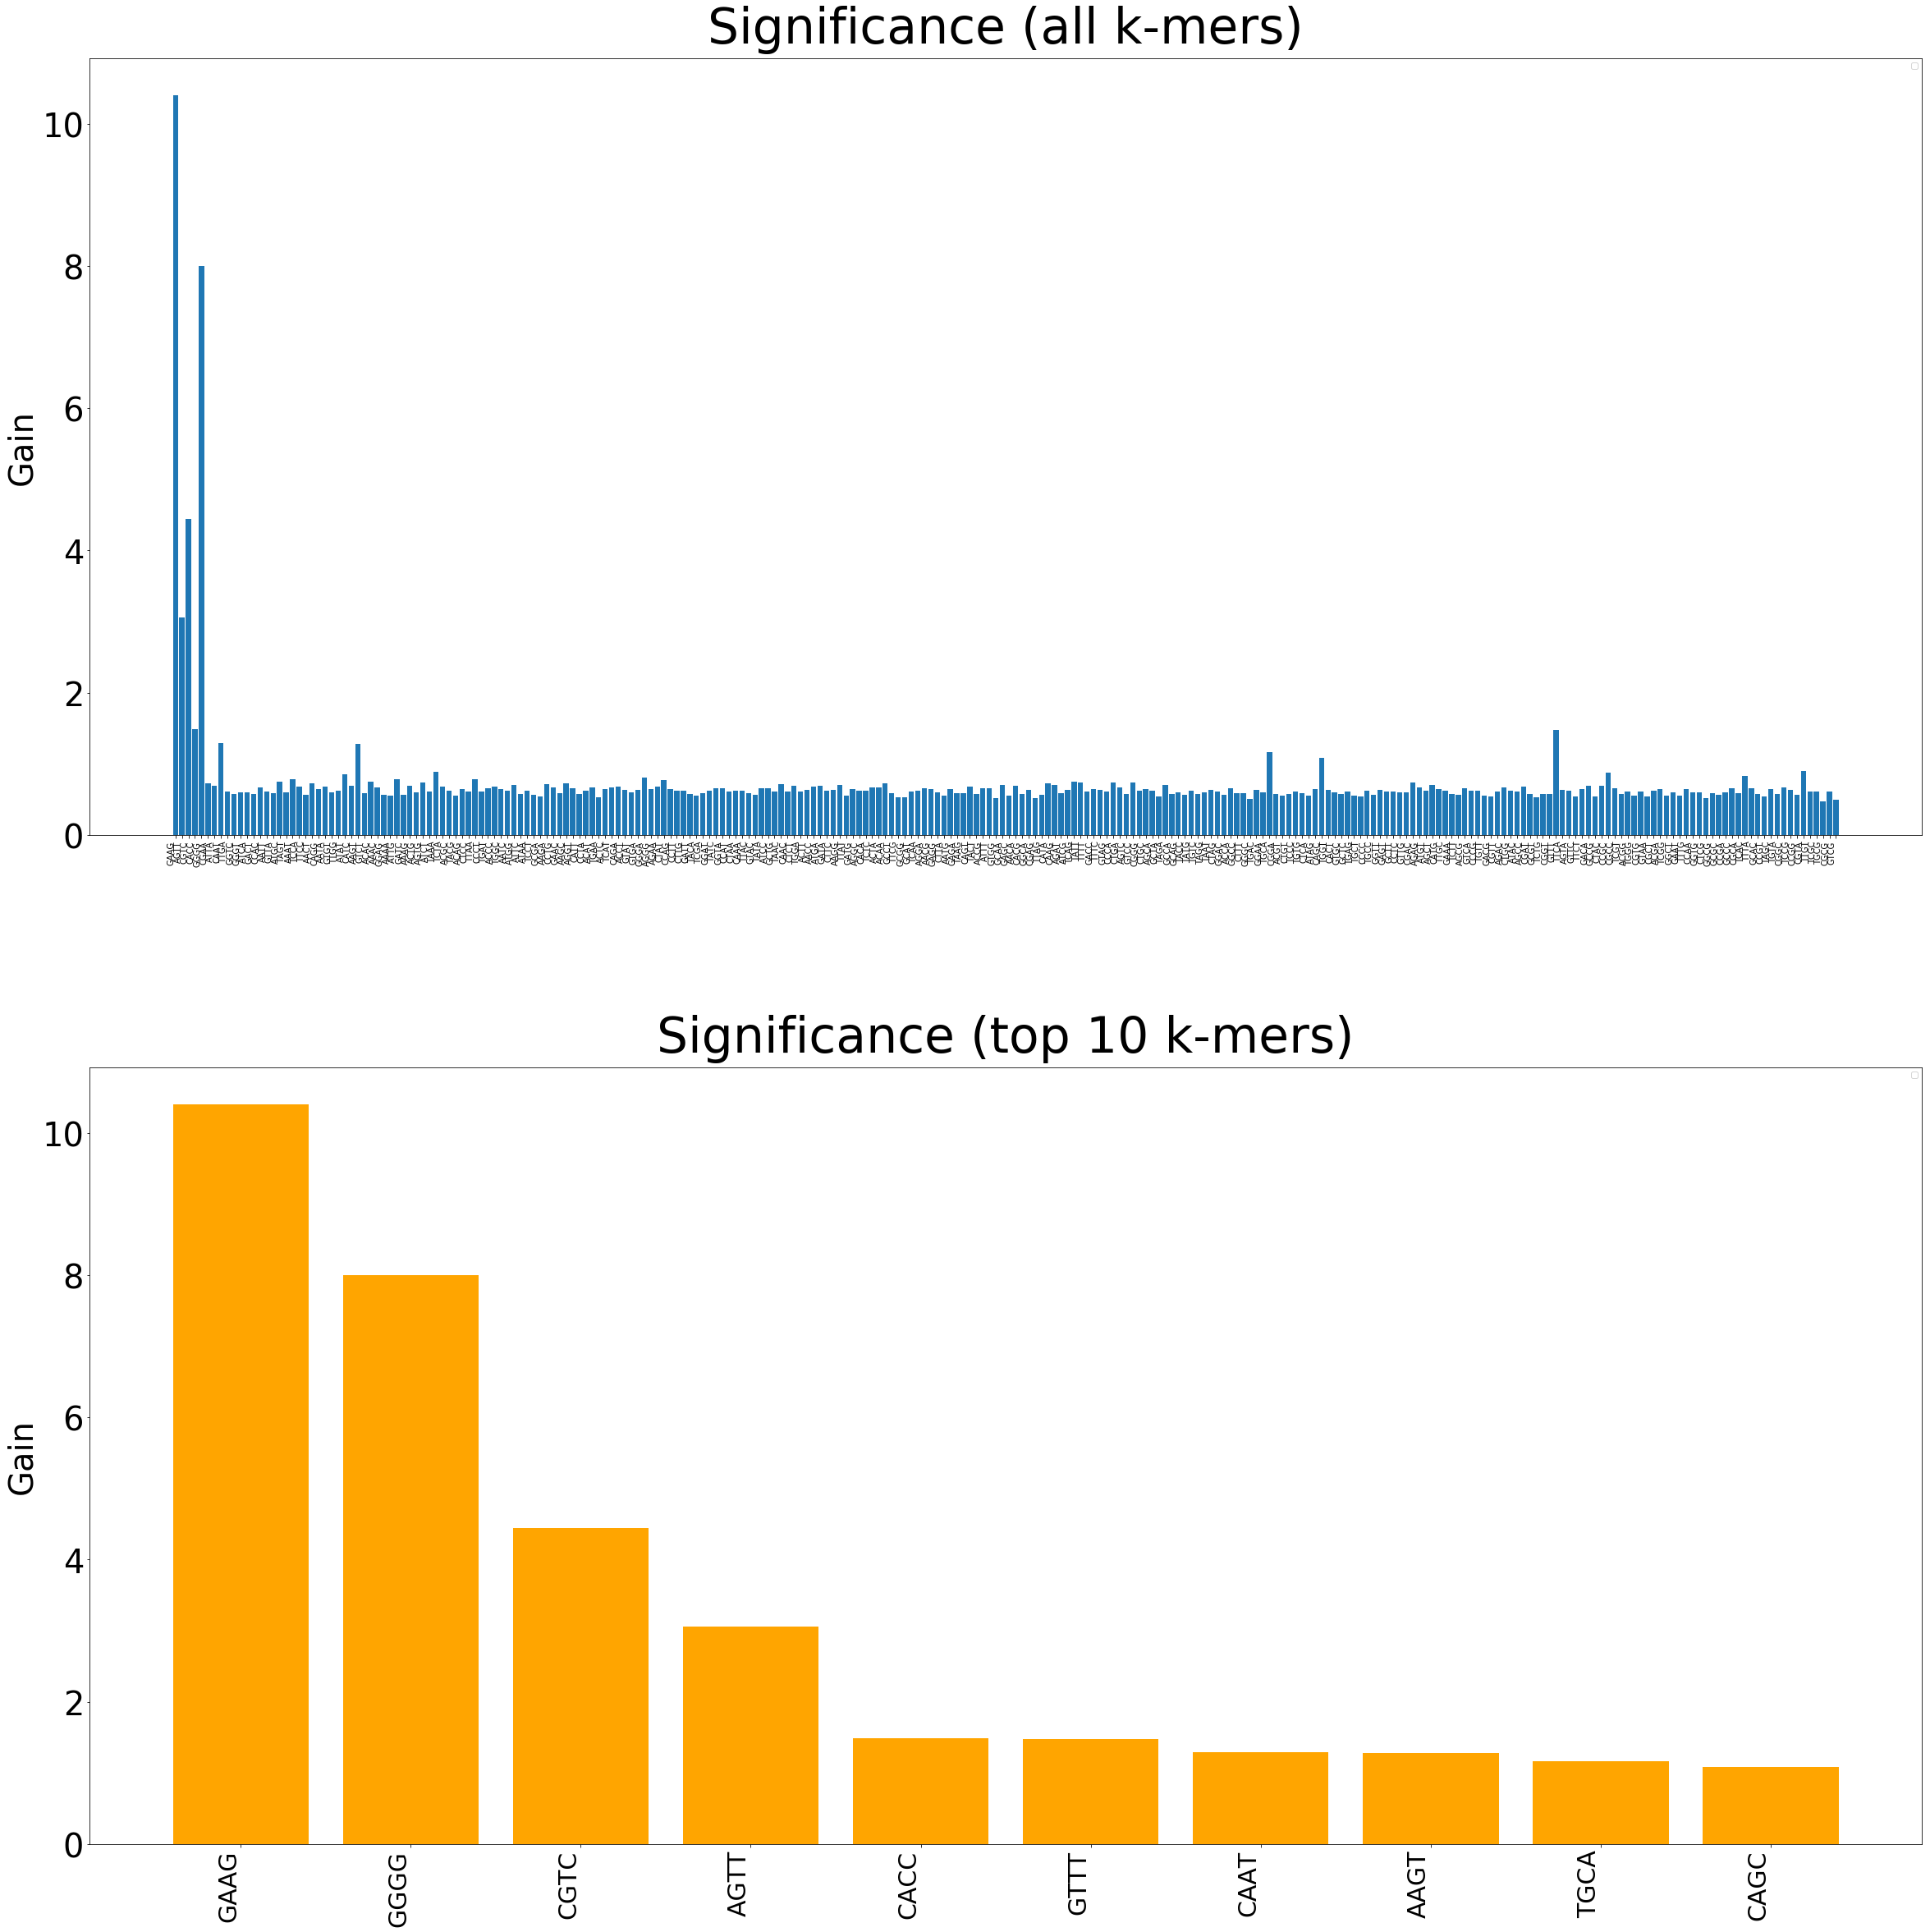

In [21]:
plt.rcParams['axes.titlesize'] = 30
plt.rc('ytick', labelsize=40)
fig = plt.figure(1, figsize=(40, 40))
gs = gridspec.GridSpec(2, 1)
ax0 = fig.add_subplot(gs[:1, :])
spec = ax0.bar(features.keys(), features.values())
ax0.set_ylabel('Gain', fontsize = 40)
ax0.set_title('Significance (all k-mers)', fontdict = {'fontsize': 60, 
                                               'fontweight' : 10,
                                               'verticalalignment': 'bottom'})
ax0.set_xticks(np.arange(len(features.keys()))) 
ax0.set_xticklabels(keys_to_fetures.values(), rotation=90,  ha="right", position=(0, 0))
ax0.legend()
ax1 = fig.add_subplot(gs[1:, :])
spec = ax1.bar(top_10_val, top_10_names, color = 'orange')
ax1.set_ylabel('Gain', fontsize = 40)
ax1.set_title('Significance (top 10 k-mers)', fontdict = {'fontsize': 60, 
                                               'fontweight' : 10,
                                               'verticalalignment': 'bottom'})
ax1.set_xticks(np.arange(len(top_10_val))) 
ax1.set_xticklabels(top_10_val, rotation=90,  ha="right", position=(0.5, 0.0), fontsize=30)
ax1.set_yticklabels
ax1.legend()
#plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('/home/pitikovegor/CourseWork/genomes/pictures/Models/features/%s_confeat.png' % modelname)
plt.show()



/home/pitikovegor/CourseWork/genomes/models/xgb_trans_15:24:35_3_GSM4041595_K562_rep2.hg38


No handles with labels found to put in legend.
No handles with labels found to put in legend.


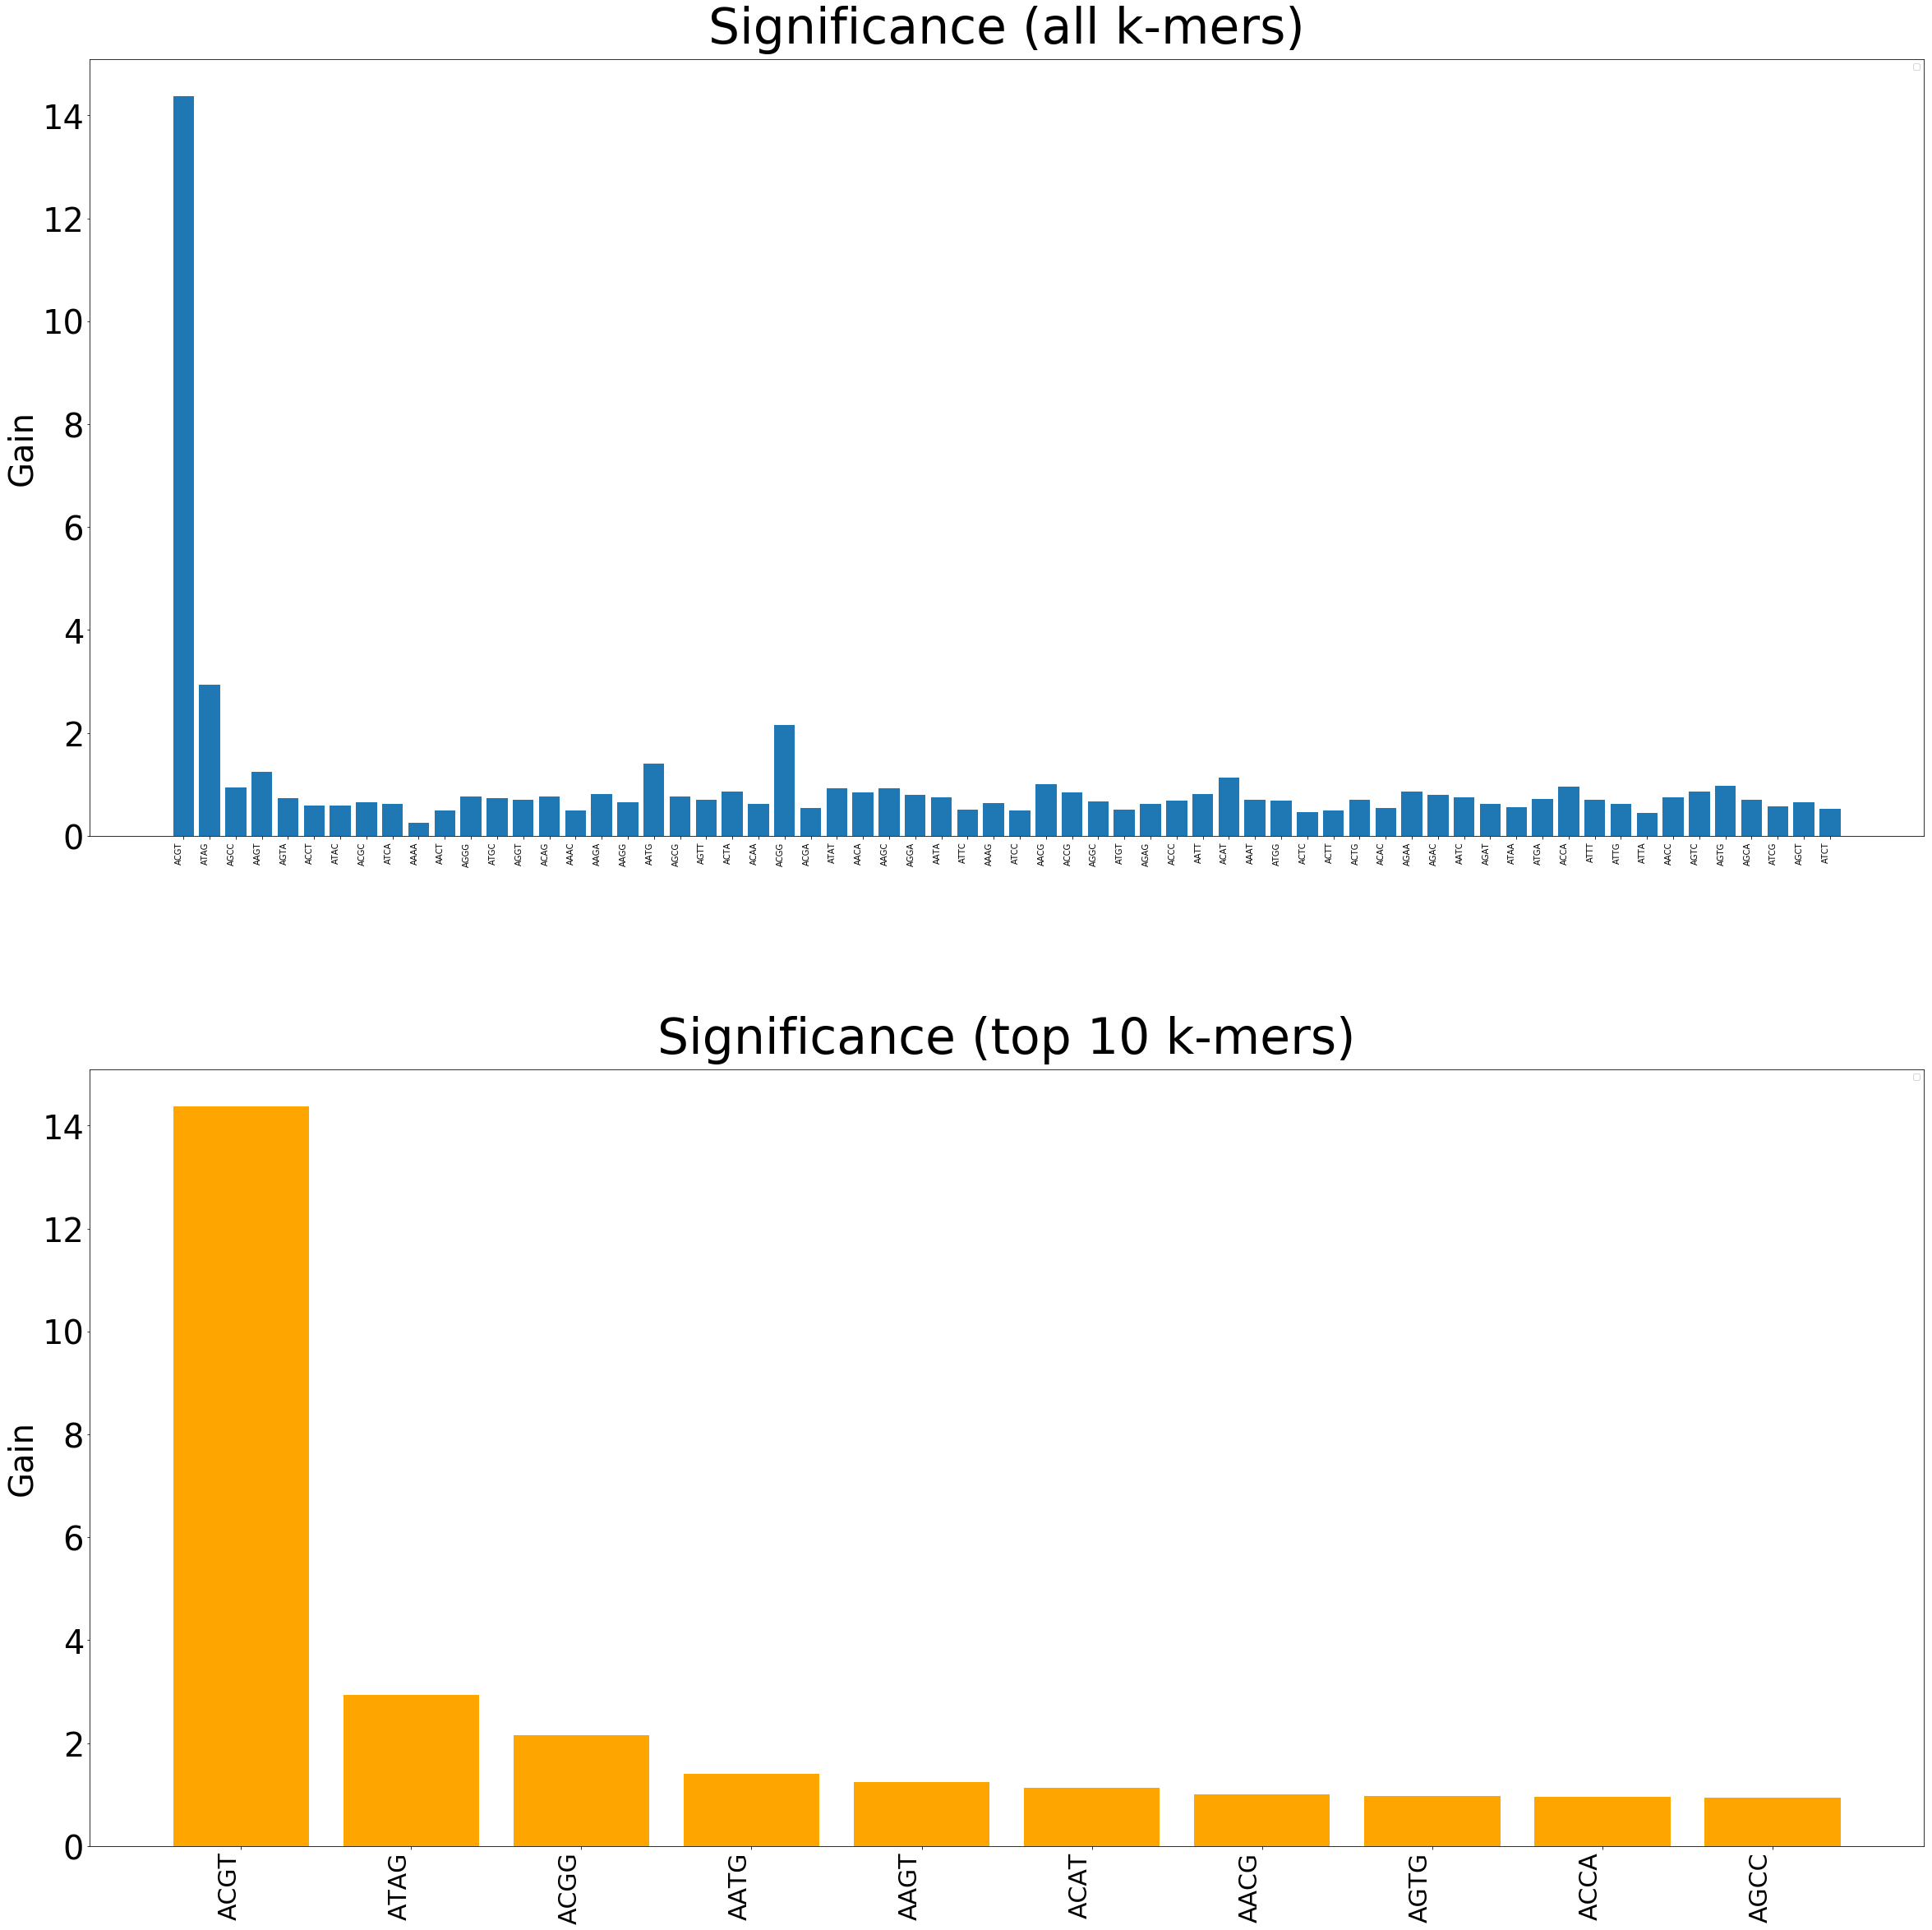

/home/pitikovegor/CourseWork/genomes/models/xgb_clusters_10:36:58_4_try2_500_10


In [ ]:
all_top_10 = {}
for modelname in all_models:
    print(modelname)
    bst = xgb.Booster({'nthread': 10})
    bst.load_model(modelname) 

    all_seqs = [''.join(i) for i in list(it.product('ATGC', repeat=4))]
    all_seqs.sort()
    features = bst.get_score(importance_type='gain')
    features_rev = {y:x for x,y in features.items()}
    if len(features)!=len(features_rev):
        #print(modelname)
        raise DolboebException('2 or more features with similar weight')
    keys_to_fetures = {i:all_seqs[int(i[1:])] for i in features.keys()}
    top_10_names = list(features_rev.keys())
    top_10_names.sort()
    top_10_names = top_10_names[-1*(min(len(top_10_names), 10)):]
    top_10_names = top_10_names[::-1]
    top_10_val = [features_rev[i] for i in top_10_names]
    top_10_val = [all_seqs[int(i[1:])] for i in top_10_val]
    all_top_10 [modelname] = top_10_val
    plt.rcParams['axes.titlesize'] = 30
    plt.rc('ytick', labelsize=40)
    globals()[f'fig{modelname}'] = plt.figure(1, figsize=(40, 40))
    gs = gridspec.GridSpec(2, 1)
    globals()[f'ax0{modelname}'] = globals()[f'fig{modelname}'].add_subplot(gs[:1, :])
    spec = globals()[f'ax0{modelname}'].bar(features.keys(), features.values())
    globals()[f'ax0{modelname}'].set_ylabel('Gain', fontsize = 40)
    globals()[f'ax0{modelname}'].set_title('Significance (all k-mers)', fontdict = {'fontsize': 60, 
                                                   'fontweight' : 10,
                                                   'verticalalignment': 'bottom'})
    globals()[f'ax0{modelname}'].set_xticks(np.arange(len(features.keys()))) 
    globals()[f'ax0{modelname}'].set_xticklabels(keys_to_fetures.values(), rotation=90,  ha="right", position=(0, 0))
    globals()[f'ax0{modelname}'].legend()
    globals()[f'ax1{modelname}'] = globals()[f'fig{modelname}'].add_subplot(gs[1:, :])
    spec = globals()[f'ax1{modelname}'].bar(top_10_val, top_10_names, color = 'orange')
    globals()[f'ax1{modelname}'].set_ylabel('Gain', fontsize = 40)
    globals()[f'ax1{modelname}'].set_title('Significance (top 10 k-mers)', fontdict = {'fontsize': 60, 
                                                   'fontweight' : 10,
                                                   'verticalalignment': 'bottom'})
    globals()[f'ax1{modelname}'].set_xticks(np.arange(len(top_10_val))) 
    globals()[f'ax1{modelname}'].set_xticklabels(top_10_val, rotation=90,  ha="right", position=(0.5, 0.0), fontsize=30)
    globals()[f'ax1{modelname}'].set_yticklabels
    globals()[f'ax1{modelname}'].legend()
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.savefig('/home/pitikovegor/CourseWork/genomes/pictures/Models/features/%s_confeat.png' % modelname.split('/')[-1])
    plt.show()
    
    

In [ ]:
import json
with open('/Users/pitikov_egor/Documents/CourseWork/genomes/pictures/Models/features/confeat.json', 'w') as f:
    json.dump(data, all_top_10)